In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("使用设备:", device)

torch.manual_seed(42)
np.random.seed(42)


使用设备: cuda


In [2]:
DATA_PATH = '/kaggle/input/short-jokes/shortjokes.csv'

if os.path.exists(DATA_PATH):
    print("找到数据文件:", DATA_PATH)
else:
    print("未找到文件，请检查路径")



找到数据文件: /kaggle/input/short-jokes/shortjokes.csv


In [3]:
class MyDataset(Dataset):
    def __init__(self):
        self.listOfWords = self.loadWords()
        self.listOfUniqueWords = self.obtainUniqueWords()
        self.id2word = {i: w for i, w in enumerate(self.listOfUniqueWords)}
        self.word2id = {w: i for i, w in enumerate(self.listOfUniqueWords)}

        unk_id = self.word2id['<unk>']
        self.listOfIds = [self.word2id.get(w, unk_id) for w in self.listOfWords]

    def loadWords(self):
        try:
            csvData = pd.read_csv(DATA_PATH)
            joke_column = None
            for col in csvData.columns:
                if 'joke' in col.lower():
                    joke_column = col
                    break

            if joke_column is None:
                joke_column = csvData.columns[0]
                print("未找到笑话列，使用第一列:", joke_column)
            else:
                print("找到笑话列:", joke_column)

            text = csvData[joke_column].str.cat(sep=' ').lower()
            return text.split(' ')

        except Exception as e:
            print("加载数据错误:", e)
            return []

    def obtainUniqueWords(self):
        wordCounts = Counter(self.listOfWords)
        min_count = 2
        filtered = {w:c for w,c in wordCounts.items() if c >= min_count}
        print("总词数:", len(wordCounts), "过滤后:", len(filtered))
        sorted_words = sorted(filtered, key=filtered.get, reverse=True)
        return ['<unk>'] + sorted_words

    def __len__(self):
        return len(self.listOfIds) - 4

    def __getitem__(self, idx):
        return (
            torch.tensor(self.listOfIds[idx:idx+4]),
            torch.tensor(self.listOfIds[idx+1:idx+5])
        )

print("\n--- 创建数据集 ---")
dataset = MyDataset()
VOCAB_SIZE = len(dataset.listOfUniqueWords)
print("词汇表大小:", VOCAB_SIZE)
print("样本数:", len(dataset))
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # 注意力后拼接 → hidden_dim*2
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.hidden_dim = hidden_dim

    def attention(self, lstm_out):
        # lstm_out: [batch, seq, hidden]
        # 得分矩阵: [batch, seq, seq]
        score = torch.bmm(lstm_out, lstm_out.transpose(1, 2))

        # softmax 注意力权重
        attn_weights = torch.softmax(score, dim=-1)

        # 计算上下文
        context = torch.bmm(attn_weights, lstm_out)
        return context

    def forward(self, x, hidden=None):
        embed = self.embedding(x)

        lstm_out, hidden = self.lstm(embed, hidden)

        context = self.attention(lstm_out)

        concat = torch.cat([lstm_out, context], dim=-1)

        output = self.fc(concat)

        return output, hidden

    def init_hidden(self, bs):
        h0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        c0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        return (h0, c0)
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # 注意力后拼接 → hidden_dim*2
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.hidden_dim = hidden_dim

    def attention(self, lstm_out):
        # lstm_out: [batch, seq, hidden]
        # 得分矩阵: [batch, seq, seq]
        score = torch.bmm(lstm_out, lstm_out.transpose(1, 2))

        # softmax 注意力权重
        attn_weights = torch.softmax(score, dim=-1)

        # 计算上下文
        context = torch.bmm(attn_weights, lstm_out)
        return context

    def forward(self, x, hidden=None):
        embed = self.embedding(x)

        lstm_out, hidden = self.lstm(embed, hidden)

        context = self.attention(lstm_out)

        concat = torch.cat([lstm_out, context], dim=-1)

        output = self.fc(concat)

        return output, hidden

    def init_hidden(self, bs):
        h0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        c0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        return (h0, c0)



--- 创建数据集 ---
找到笑话列: Joke
总词数: 191284 过滤后: 77741
词汇表大小: 77742
样本数: 4071137


In [4]:
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # 注意力后拼接 → hidden_dim*2
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.hidden_dim = hidden_dim

    def attention(self, lstm_out):
        # lstm_out: [batch, seq, hidden]
        # 得分矩阵: [batch, seq, seq]
        score = torch.bmm(lstm_out, lstm_out.transpose(1, 2))

        # softmax 注意力权重
        attn_weights = torch.softmax(score, dim=-1)

        # 计算上下文
        context = torch.bmm(attn_weights, lstm_out)
        return context

    def forward(self, x, hidden=None):
        embed = self.embedding(x)

        lstm_out, hidden = self.lstm(embed, hidden)

        context = self.attention(lstm_out)

        concat = torch.cat([lstm_out, context], dim=-1)

        output = self.fc(concat)

        return output, hidden

    def init_hidden(self, bs):
        h0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        c0 = torch.zeros(1, bs, self.hidden_dim).to(device)
        return (h0, c0)


In [5]:
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 256
EPOCHS = 10
LR = 0.001

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = AttentionLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("模型参数数量:", sum(p.numel() for p in model.parameters()))


模型参数数量: 50227886



--- 开始训练（带日志） ---
Epoch 1/10 | Loss = 2.0880 | Acc = 0.7309
Epoch 2/10 | Loss = 1.5204 | Acc = 0.7845
Epoch 3/10 | Loss = 1.4558 | Acc = 0.7917
Epoch 4/10 | Loss = 1.4209 | Acc = 0.7955
Epoch 5/10 | Loss = 1.3937 | Acc = 0.7980
Epoch 6/10 | Loss = 1.3736 | Acc = 0.7996
Epoch 7/10 | Loss = 1.3562 | Acc = 0.8011
Epoch 8/10 | Loss = 1.3426 | Acc = 0.8024
Epoch 9/10 | Loss = 1.3315 | Acc = 0.8035
Epoch 10/10 | Loss = 1.3222 | Acc = 0.8044
--- 训练完成 ---
模型已保存到: /kaggle/working/attention_lstm_joke.pth


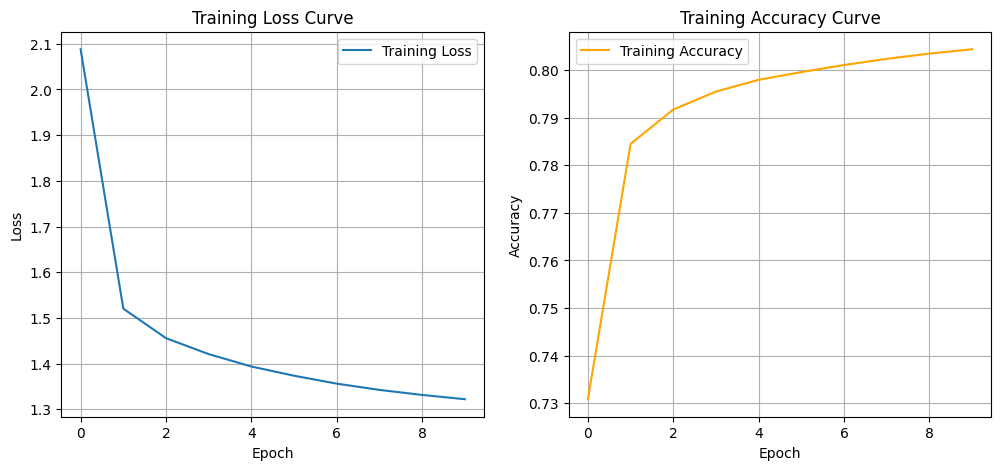

In [6]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ================
# 训练日志记录
# ================
train_losses = []
train_accs = []

print("\n--- 开始训练（带日志） ---")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs, _ = model(inputs)

        # outputs: [batch, seq, vocab]
        # targets: [batch, seq]
        loss = criterion(outputs.view(-1, VOCAB_SIZE), targets.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # ======================
        #    计算训练准确率
        # ======================
        pred = outputs.argmax(dim=-1)        # [batch, seq]
        correct += (pred == targets).sum().item()
        total += targets.numel()

    avg_loss = total_loss / len(dataloader)
    acc = correct / total

    train_losses.append(avg_loss)
    train_accs.append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss = {avg_loss:.4f} | Acc = {acc:.4f}")

print("--- 训练完成 ---")


# =============================
#   保存模型到 /kaggle/working/
# =============================
MODEL_PATH = "/kaggle/working/attention_lstm_joke.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("模型已保存到:", MODEL_PATH)


# =============================
#   绘制 Loss / Accuracy 曲线
# =============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Training Accuracy", color='orange')
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()


In [7]:
MODEL_PATH = "attention_lstm_joke.pth"
torch.save(model.state_dict(), MODEL_PATH)

print("模型已保存到:", MODEL_PATH)

模型已保存到: attention_lstm_joke.pth
